In [1]:
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from giae.so2.data import MNISTDataModule, MNISTDataset
from torch.utils.data import Dataset, DataLoader
from giae.so2.trainer import Trainer
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, GaussianBlur
from PIL import Image
import escnn
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# import mlflow
# from serotiny.ml_ops.mlflow_utils import download_artifact, load_model_from_checkpoint, _get_config

# model = load_model_from_checkpoint("https://mlflow.a100.int.allencell.org", "6dadf6383beb453ebff7b0f1b6b5544a", {})

In [46]:
import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact, load_model_from_checkpoint, _get_config
# b72f62c762aa4afb934c737deeddb995 # no pool
# 5326aa3031b347319e8dfc5e82964fd4 # pool

# 95595f7c1f8d4566b1aba64fbaf73632 # good
model = load_model_from_checkpoint("https://mlflow.a100.int.allencell.org", "cd3f42878f844eae8f293e5448d88b51", {})

In [47]:
# import mlflow
# from serotiny.ml_ops.mlflow_utils import download_artifact, load_model_from_checkpoint, _get_config

# model = load_model_from_checkpoint("https://mlflow.a100.int.allencell.org", "cae02eebdfc443a39466faa4de4f40ae", {})

In [48]:
model.mode = '2d'


In [49]:
device = "cuda:0"
model = model.to(device)
inp = torch.zeros([2,28,28]).to(device)
# hh = model.encoder['image'].conv_forward(inp, return_sizes=True)

In [50]:
device = "cuda:0"
model = model.eval()
model.to(device)

EqImageVAE(
  (encoder): ModuleDict(
    (image): Encoder(
      (block1): SequentialModule(
        (0): R2Conv([Continuous-Rotations: {irrep_0}], [Continuous-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, irrep_1, 

In [8]:
from hydra.utils import instantiate
import yaml

data = instantiate(yaml.full_load('''
  _target_: serotiny.datamodules.ManifestDatamodule
  path: /allen/aics/modeling/bvae_analysis/data/cytodata/variance_2000.csv
  batch_size: 20
  num_workers: 0
  loaders:
    image:
      _target_: serotiny.io.dataframe.loaders.LoadImage
      column: max_projection_z
      select_channels:
      - membrane_segmentation
      dtype: float32
      unsqueeze_first_dim: true
      transform:
      - _target_: torchvision.transforms.ToTensor
      - _partial_: true
        _convert_: all
        _target_: torch.swapaxes
        axis0: 0
        axis1: 1
      - _partial_: true
        _convert_: all
        _target_: torch.swapaxes
        axis0: 1
        axis1: 2
      - _target_: torchvision.transforms.CenterCrop
        size: 374
      - _partial_: true
        _target_: aics_latentspaces.transform_utils.center_image
      - _target_: torchvision.transforms.Resize
        size: 28
      - _target_: torchvision.transforms.Normalize
        mean:
        - 0
        std:
        - 1
      - _partial_: true
        _target_: torch.squeeze
    cell_id:
      _target_: serotiny.io.dataframe.loaders.LoadColumns
      contains: CellId
    class:
      _target_: serotiny.io.dataframe.loaders.LoadColumns
      contains: nbr_complete
  split_column: split
  columns: null
'''))

28-Nov-22 16:10:31 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).
To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init(runtime_env={'env_vars': {'__MODIN_AUTOIMPORT_PANDAS__': '1'}})

2022-11-28 16:10:34,402	INFO worker.py:1518 -- Started a local Ray instance.
Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


In [9]:
1

1

In [10]:
dl = next(iter(data.test_dataloader()))

In [40]:
dl['image'].shape

torch.Size([20, 28, 28])

In [51]:
size =28
resize2 = Resize((size, size))
totensor = ToTensor()
blur = GaussianBlur(kernel_size=3, sigma=(0.01, 0.01))

# GENERATE rotated versions. Resize to minimize interploation artifacts
i = 9 # 9 for DNA
i = 2 # 0 for DNA
img_ind = 6 # for mem
x =  dl['image'][img_ind]
try:
    print(dl['id'][img_ind])
except:
    print(dl['cell_id'][img_ind])
x_r = Image.fromarray(x.numpy())
# x_r = torch.cat((
#     totensor(resize2(blur(x_r.rotate(0*90., Image.BILINEAR)))).reshape(1, 28, 28),
#     totensor(resize2(blur(x_r.rotate(0.5*90., Image.BILINEAR)))).reshape(1, 28, 28),
#     totensor(resize2(blur(x_r.rotate(1*90., Image.BILINEAR)))).reshape(1, 28, 28),
#     totensor(resize2(blur(x_r.rotate(1.5*90., Image.BILINEAR)))).reshape(1, 28, 28),
#     totensor(resize2(blur(x_r.rotate(2*90., Image.BILINEAR)))).reshape(1, 28, 28),
#     totensor(resize2(blur(x_r.rotate(2.5*90., Image.BILINEAR)))).reshape(1, 28, 28),
#     totensor(resize2(blur(x_r.rotate(3.*90., Image.BILINEAR)))).reshape(1, 28, 28),
#     totensor(resize2(blur(x_r.rotate(3.5*90., Image.BILINEAR)))).reshape(1, 28, 28)), dim=0)
# x_r.shape

x_r = torch.cat((
    totensor(resize2(blur(x_r.rotate(0*90., Image.BILINEAR)))).reshape(1, size, size),
    totensor(resize2(blur(x_r.rotate(0.5*90., Image.BILINEAR)))).reshape(1, size, size),
    totensor(resize2(blur(x_r.rotate(1*90., Image.BILINEAR)))).reshape(1, size, size),
    totensor(resize2(blur(x_r.rotate(1.5*90., Image.BILINEAR)))).reshape(1, size, size),
    totensor(resize2(blur(x_r.rotate(2*90., Image.BILINEAR)))).reshape(1, size, size),
    totensor(resize2(blur(x_r.rotate(2.5*90., Image.BILINEAR)))).reshape(1, size, size),
    totensor(resize2(blur(x_r.rotate(3.*90., Image.BILINEAR)))).reshape(1, size, size),
    totensor(resize2(blur(x_r.rotate(3.5*90., Image.BILINEAR)))).reshape(1, size, size)), dim=0)
x_r.shape

tensor([270439.], dtype=torch.float64)


torch.Size([8, 28, 28])

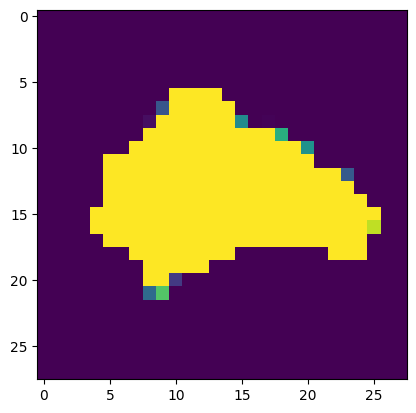

In [52]:
plt.imshow(x_r[0])

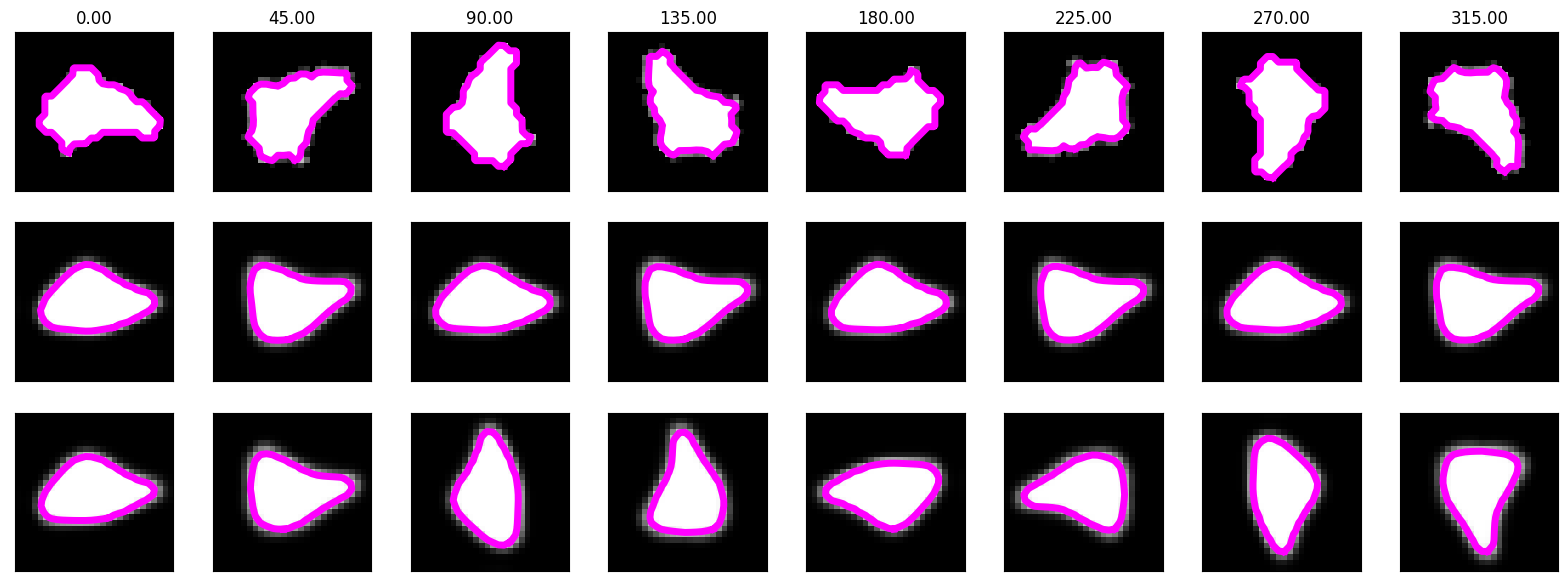

In [53]:
from skimage import measure
device = "cuda:0"
x_r = {'image': x_r.to(device)}

model.to(device)
with torch.no_grad():
    y, _, z_parts_params_1, _, _, _, _, _ = model(x_r, do_rot=False, decode=True, compute_loss=True)
    y2, _, z_parts_params_2, _, _, _, _, _  = model(x_r, do_rot=True, decode=True, compute_loss=True)
    y = y['image'].cpu().numpy()
    y2 = y2['image'].cpu().numpy()
    if 'angle' in z_parts_params_1.keys():
        rot_1 = z_parts_params_1['angle'].cpu().numpy()
        rot_2 = z_parts_params_2['angle'].cpu().numpy()
       
fig, ax = plt.subplots(nrows=3, ncols=8, figsize=(20, 7))
theta = torch.Tensor([0, 0.5*90, 1*90, 1.5*90, 2*90, 2.5*90, 3*90, 3.5*90])
for i in range(len(theta)):
    
    inp = x_r['image'][i].detach().cpu().numpy()
    contour_inp = measure.find_contours(inp, 0.8)[0]
    ax[0, i].imshow(inp, cmap="gray")
    ax[0, i].plot(contour_inp[:, 1], contour_inp[:, 0],  color='magenta',linewidth=5)
    
    contour_yi = measure.find_contours(y[i], 0.8)[0]
    contour_y2i = measure.find_contours(y2[i], 0.8)[0]
    ax[1, i].imshow(y[i], cmap="gray")
    ax[1, i].plot(contour_yi[:, 1], contour_yi[:, 0], color='magenta', linewidth=5)
    ax[2, i].imshow(y2[i], cmap="gray")
    ax[2, i].plot(contour_y2i[:, 1], contour_y2i[:, 0], color='magenta', linewidth=5)
    ax[0, i].set_title("%.2f" % (theta[i].numpy()))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()
#fig.savefig('./pngs_poster/2D_vae_rotate_showequivbyrotation.png')

In [45]:
measure.find_contours(y[i], 0.8)

[]

In [44]:
y[i].shape

(28, 28)

In [507]:
x_r['image'].shape

torch.Size([8, 28, 28])

In [584]:
ind = 1
img_in = x_r['image'][ind].detach().cpu().numpy()
img_recon = y[ind]
img_recon2 = y2[ind]

In [585]:
# fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (10,5))
# contour = measure.find_contours(img_in, 0.8)[0]
# ax.imshow(img_in, cmap=plt.cm.gray)
# ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# contour = measure.find_contours(img_recon, 0.8)[0]
# ax1.imshow(img_recon, cmap=plt.cm.gray)
# ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)

# contour = measure.find_contours(img_recon2, 0.8)[0]
# ax2.imshow(img_recon2, cmap=plt.cm.gray)
# ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [586]:
from skimage import measure
def save_plot(img_in, img_recon, img_recon2, i, filenames):
    fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (10,5))
    contour = measure.find_contours(img_in, 0.8)[0]
    ax.imshow(img_in, cmap=plt.cm.gray)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    contour = measure.find_contours(img_recon, 0.8)[0]
    ax1.imshow(img_recon, cmap=plt.cm.gray)
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)

    contour = measure.find_contours(img_recon2, 0.8)[0]
    ax2.imshow(img_recon2, cmap=plt.cm.gray)
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    fig.savefig(filename)
    plt.close()
    return filenames

In [587]:
filenames = []
# for ind in range(8):
for ind in [0, 2, 4, 6]:
    img_in = x_r['image'][ind].detach().cpu().numpy()
    img_recon = y[ind]
    img_recon2 = y2[ind]
    filenames = save_plot(img_in, img_recon, img_recon2, ind, filenames)
    

In [588]:
import imageio
import os

In [589]:
img_ind

6

In [590]:

# for i in y:
#     # plot the line chart
#     plt.plot(y[:i])
#     plt.ylim(20,50)
    
#     # create file name and append it to a list
#     filename = f'{i}.png'
#     filenames.append(filename)
    
#     # save frame
#     plt.savefig(filename)
#     plt.close()
# build gif
with imageio.get_writer(f'2d_gifs/{img_ind}.gif', mode='I', fps=2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [390]:
# # Display the image and plot all contours found
# fig, ax = plt.subplots()
# ax.imshow(img_in, cmap=plt.cm.gray)

# for contour in contours:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [292]:
y2.shape

(8, 28, 28)

In [293]:
y.shape

(8, 28, 28)